In [1]:
import torch
import torch.functional as F
import os
from torch.utils.data import Dataset
import random

In [2]:
os.chdir('/content/drive/MyDrive/DataML/HyperspectralData')

In [3]:
class HyperDataset(Dataset):

  def __init__(self, train_test_tuples, train = True):
    self.y = []
    self.X = []
    self.train = train
    for train_test_tuple in train_test_tuples:
      X_temp = train_test_tuple.train_set if train else train_test_tuple.test_set
      self.X.append(X_temp)
      self.y.extend([train_test_tuple.label for i in range(X_temp.shape[0])])
    self.y = torch.Tensor(self.y)
    self.X = torch.cat(self.X)
  
  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, ndx):
    return tuple([self.X[ndx,:], self.y[ndx]])



In [4]:
train_set = torch.load('/content/drive/MyDrive/DataML/HyperspectralData/train_set.pt')
test_set = torch.load('/content/drive/MyDrive/DataML/HyperspectralData/test_set.pt')
zero_label = torch.load('/content/drive/MyDrive/DataML/HyperspectralData/zero_label.pt')

In [47]:
class ZeroSet(Dataset):


  def __init__(self, train_set, test_set, zero_label, train = True):

    self.y = torch.Tensor(train_set.X.shape[0] * [0] + test_set.X.shape[0] * [1])
    self.X = torch.cat([train_set.X, test_set.X])
    indices = [i for i in range(len(self.y))]
    random.seed(200)
    random.shuffle(indices)
    self.y = self.y[indices]
    self.X = self.X[indices, :]
    length = len(self.y)
    if train:
      self.y = self.y[:int(length * 0.75)]
      self.X = self.X[:int(length * 0.75), :]
    else:
      self.y = self.y[int(length * 0.75):]
      self.X = self.X[int(length * 0.75):, :]
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self, ndx):
    return (self.X[ndx,:], self.y[ndx])

  

In [48]:
set_train = ZeroSet(train_set, test_set, zero_label, train = True)
set_test = ZeroSet(train_set, test_set, zero_label, train = False)

In [49]:
class ModelSimple(torch.nn.Module):

  def __init__(self):
    super(ModelSimple, self).__init__()
    self.fc1 = torch.nn.Linear(25*25*30, 1000)
    self.fc2 = torch.nn.Linear(1000,100)
    self.fc3 = torch.nn.Linear(100, 1)
  
  def forward(self, X):
    X = X.view(-1, 25*25*30)
    X = torch.relu(self.fc1(X))
    X = torch.relu(self.fc2(X))
    X = torch.sigmoid(self.fc3(X))
    return X


In [60]:
fast_model = ModelSimple()
device = torch.device('cuda') 
fast_model = fast_model.to(device)

In [61]:
fast_model(set_train[0][0].to(device))

tensor([[0.5314]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [62]:
set_train[0:5][1].shape

torch.Size([5])

In [63]:
import tqdm
import numpy as np

In [64]:
loss = torch.nn.BCELoss()
optimizer = torch.optim.SGD(fast_model.parameters(), lr=0.001, momentum = 0.9)
losses_train = []
losses_test = []

train_loader = torch.utils.data.DataLoader(set_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(set_test, batch_size=32, shuffle=True)

epochs = 10

for i in tqdm.tqdm(range(epochs)):

  batch_loss_train = []
  fast_model.train()
  for X_batch, y_batch in train_loader:
    optimizer.zero_grad()
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    predictions = fast_model(X_batch)
    loss_val = loss(predictions, y_batch.unsqueeze(-1))
    batch_loss_train.append(loss_val.item())
    loss_val.backward()
    optimizer.step()
  losses_train.append(np.mean(batch_loss_train))

  fast_model.eval()
  batch_loss_test = []
  for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    predictions = fast_model(X_batch)
    loss_val = loss(predictions, y_batch.unsqueeze(-1))
    batch_loss_test.append(loss_val.item())
  losses_test.append(np.mean(batch_loss_test))




100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


In [65]:
import matplotlib.pyplot as plt

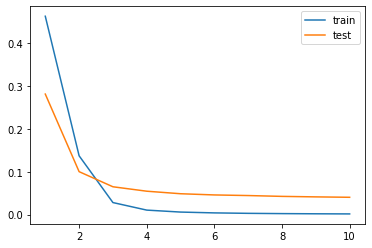

In [68]:
x = np.linspace(1,10,10)
plt.plot(x, losses_train, label = 'train')
plt.plot(x, losses_test, label = 'test')
plt.legend()
plt.show()



In [70]:
fast_model.eval()
X = set_test.X.to(device)
predictions_all = fast_model(X)

In [85]:
predictions_all = predictions_all.view(-1,).round().long()

In [80]:
y = set_test.y.to(device)

In [82]:
y.long()

tensor([1, 0, 1,  ..., 0, 1, 0], device='cuda:0')

In [88]:
sum(predictions_all == y.long())/len(y.long())

tensor(0.9867, device='cuda:0')